In [1]:
import kecam
%matplotlib inline

import os
import tensorflow as tf
import numpy as np
from pathlib import Path
from PIL import Image

- Img and model selection :

In [8]:
#mm = kecam.yolor.YOLOR_CSP()
#model = "yolor_csp"
model_path = "models/EfficientDetD0_640_LAMB_coco.json_batchsize_64_randaug_6_mosaic_0.5_color_random_hsv_position_rts_lr512_0.008_wd_0.02_anchors_mode_None_latest.h5"
model = "effecientdet_lard"
mm = kecam.efficientdet.EfficientDetD0(input_shape=(None, 640, 640, 3),num_classes=1, pretrained=model_path)
#model_path = "models/YOLOV7_Tiny_640_LAMB_._lard.json_batchsize_128_randaug_6_mosaic_0.5_color_random_hsv_position_rts_lr512_0.008_wd_0.02_anchors_mode_None_epoch_30_val_ap_ar_0.5211.h5"
#model= "yolov7_augustin"
#mm = kecam.yolov7.YOLOV7_Tiny(input_shape=(None, 640, 640, 3),num_classes=1, pretrained=model_path)

#mm = tf.keras.models.load_model(model_path, compile=False)
imm_orig = np.array(Image.open("KJFK_22L_35_29.jpeg"))
img_name = "KJFK_22L_35_29"
#img_name = "CYUL_06L_35_18"
#imm_orig = np.array(Image.open("../datasprint/data/newYoloFormat/test/images/CYUL_06L_35_18.jpeg"))

#imm_orig = kecam.test_images.dog_cat()
#img_name = "cat_dog"

>>>> features: {'stack_2_block1_output': TensorShape([None, 80, 80, 40]), 'stack_4_block2_output': TensorShape([None, 40, 40, 112]), 'stack_6_block0_output': TensorShape([None, 20, 20, 320])}
>>>> num_anchors: 9
>>>> Load pretrained from: models/EfficientDetD0_640_LAMB_coco.json_batchsize_64_randaug_6_mosaic_0.5_color_random_hsv_position_rts_lr512_0.008_wd_0.02_anchors_mode_None_latest.h5


- get model prediction for image :

(2048, 2448, 3)
(1, 76725, 5)


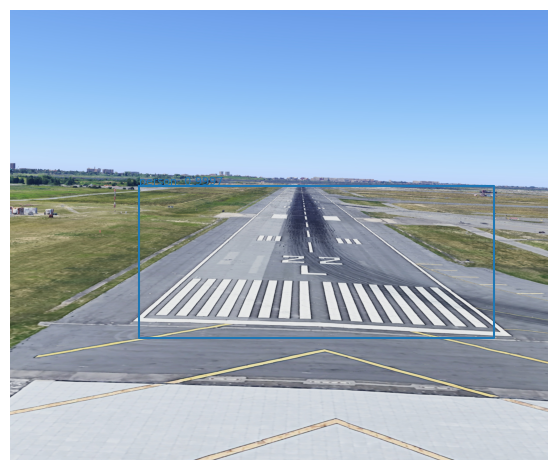

<Axes: >

In [9]:

print(imm_orig.shape)
imm = mm.preprocess_input([imm_orig])
preds = mm(imm)

print(preds.shape)
preds = mm.decode_predictions(preds)
bboxs, lables, confidences = preds[0]
kecam.coco.show_image_with_bboxes(imm_orig, bboxs, lables, confidences)

- Choose your explanation method :

In [10]:
from xplique_test import Explainer
Explainer.methods

{'ig': xplique.attributions.integrated_gradients.IntegratedGradients,
 'saliency': xplique.attributions.saliency.Saliency,
 'deconvnet': xplique.attributions.deconvnet.DeconvNet,
 'gradient_input': xplique.attributions.gradient_input.GradientInput,
 'guided_backprop': xplique.attributions.guided_backpropagation.GuidedBackprop,
 'sobol': xplique.attributions.global_sensitivity_analysis.sobol_attribution_method.SobolAttributionMethod,
 'smoothgrad': xplique.attributions.smoothgrad.SmoothGrad}

In [11]:
"""
explainer = Explainer(mm)
method = "sobol"
params = {
    "batch_size": 16,
    "grid_size": 16,
    "nb_design": 16
}
explanation = explainer.apply(method, preds, imm, params)"""

'\nexplainer = Explainer(mm)\nmethod = "sobol"\nparams = {\n    "batch_size": 16,\n    "grid_size": 16,\n    "nb_design": 16\n}\nexplanation = explainer.apply(method, preds, imm, params)'

In [14]:

explainer = Explainer(mm)
method = "deconvnet"
params = {
    "batch_size": 16
}
explanation = explainer.apply(method, preds, imm, params)

boxes_refs (1, None, 4)
class_refs (1, None, 20)
classification_similarity <unknown>
proba_detection <unknown>
boxes_pairwise_scores <unknown>
ref_boxes_scores <unknown>
image_score ()
printing output------------
[1 100 25]
Before batch loop
images_score TensorShape([None])


In [12]:
explainer = Explainer(mm)
method = "smoothgrad"
params = {
    "batch_size": 16,
    "nb_samples": 50,
    "noise": 0.069
}
explanation = explainer.apply(method, preds, imm, params)

boxes_refs (1, None, 4)
class_refs (1, None, 20)
classification_similarity <unknown>
proba_detection <unknown>
boxes_pairwise_scores <unknown>
ref_boxes_scores <unknown>
image_score ()
printing output------------
[16 100 25]
Before batch loop
images_score TensorShape([None])
printing output------------
[16 100 25]
Before batch loop
images_score TensorShape([None])
printing output------------
[16 100 25]
Before batch loop
images_score TensorShape([None])
boxes_refs (1, None, 4)
class_refs (1, None, 20)
classification_similarity <unknown>
proba_detection <unknown>
boxes_pairwise_scores <unknown>
ref_boxes_scores <unknown>
image_score ()
printing output------------
[2 100 25]
Before batch loop
images_score TensorShape([None])


- visualize and save the image :

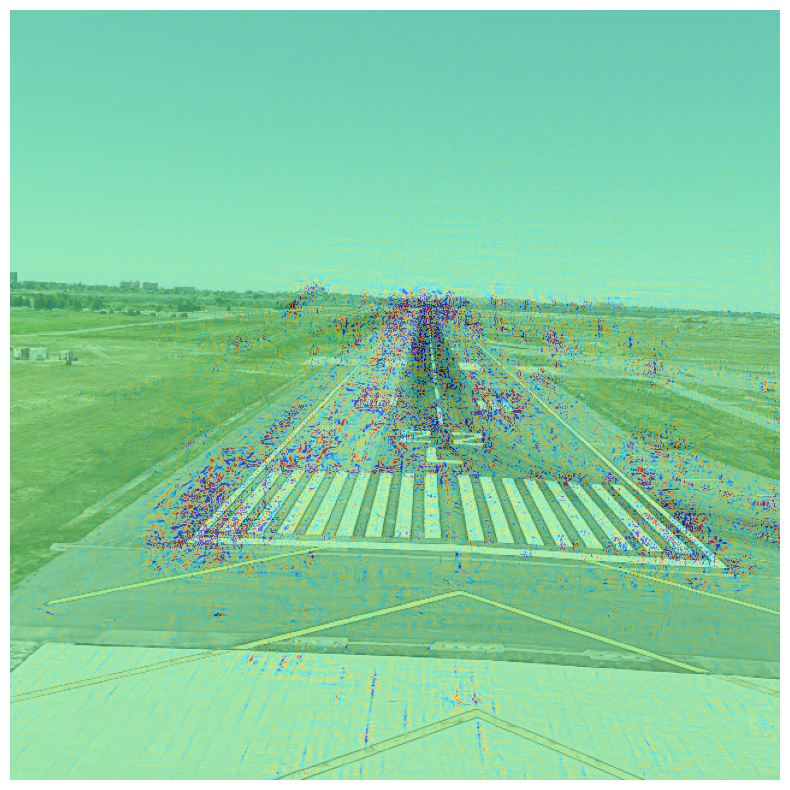

In [13]:
explainer.visualize(exp_name=f"{model}_{img_name}", dest_folder="img")

- evaluate or compare explanation(s) relevancy :

In [ ]:
explainer.metrics

In [ ]:
value = explainer.score("mufidelity", explanation, imm, preds, {"batch_size":32, "nb_samples":50})
print("explanation score: ", value)

In [ ]:
# In the case of average stability, divide it by the number of pixel to have the value per explained pixel :
#as_value = explainer.score("average_stability", explanation, imm, preds, {"batch_size":32, "nb_samples":100,"radius":1.0, "distance":'l1'})

#print("Normalized score per pixel for average stability : ", as_value / int(tf.size(explanation)))

In [ ]:
#print("Normalized score per pixel for average stability : ", value / int(tf.size(explanation)))

In [ ]:
deletion_value = explainer.score("deletion", explanation, imm, preds, {"batch_size":32})

In [ ]:
print(deletion_value)

In [ ]:
insertion = explainer.score("insertion", explanation, imm, preds, {"batch_size":32})

In [ ]:
print(insertion)

In [ ]:
for method in explainer.methods.keys():
    params = {
        "batch_size":16
    }
    try:
        explanation = explainer.apply(method, preds, imm, params)
        insertion = explainer.score("insertion", explanation, imm, preds, {"batch_size":64})
        deletion_value = explainer.score("deletion", explanation, imm, preds, {"batch_size":64})
        explainer.visualize(exp_name=f"{model}_{img_name}_insertion_{insertion}_deletion_{deletion_value}_mbs_64", dest_folder="img")
    except TypeError:
        print("Method ", method, "encountered type error")

In [ ]:
explanation.shape

In [ ]:
imm.shape